# Rotation

<div class="btn btn-notebook" role="button">
    <img src="../_static/images/colab_logo_32px.png"> [Run in Google Colab](https://colab.research.google.com/drive/1XePW12UF80PKzvLu9cyRJKWQoZIxk_J2?usp=sharing)
</div>
<div class="btn btn-notebook" role="button">
    <img src="../_static/images/github_logo_32px.png"> [View on GitHub](https://github.com/adapt-python/adapt/blob/master/docs/examples/Rotation.ipynb)
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from adapt.feature_based import CORAL, DeepCORAL, DANN, ADDA, mSDA

## Setup

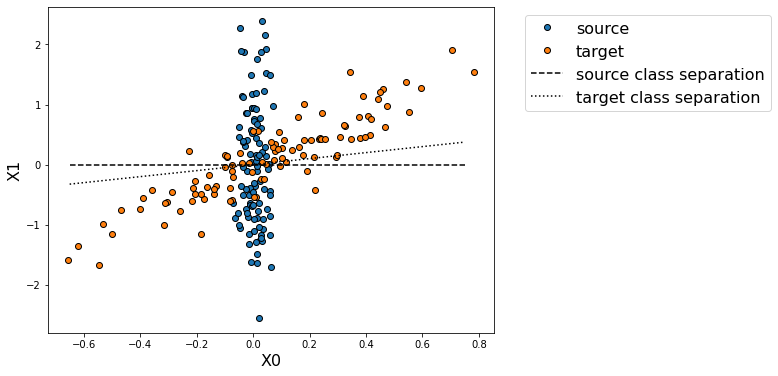

In [2]:
np.random.seed(0)
Xs = np.random.multivariate_normal(
     np.array([0, 0]), np.array([[0.001, 0], [0, 1]]), 100)
Xt = np.random.multivariate_normal(
     np.array([0, 0]), np.array([[0.1, 0.2], [0.2, 0.5]]), 100)
ys = np.zeros(100)
yt = np.zeros(100)
ys[Xs[:, 1]>0] = 1
yt[(Xt[:, 1]-0.5*Xt[:, 0])>0] = 1

x_grid, y_grid = np.meshgrid(np.linspace(-0.65, 0.75, 100),
                             np.linspace(-2.1, 2.1, 100))
X_grid = np.stack([x_grid.ravel(), y_grid.ravel()], -1)

cm = matplotlib.colors.ListedColormap(['w', 'r', 'w'])
plt.figure(figsize=(8,6))
plt.plot(Xs[:, 0], Xs[:, 1], 'o', markeredgecolor="k", label="source")
plt.plot(Xt[:, 0], Xt[:, 1], 'o', markeredgecolor="k", label="target")
plt.plot([-0.65, 0.75], [0, 0], c="black", ls="--", label="source class separation")
plt.plot([-0.65, 0.75], [-0.65*0.5, 0.75*0.5], c="black", ls=":", label="target class separation")
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("X0", fontsize=16), plt.ylabel("X1", fontsize=16)
plt.show()

## Source Only

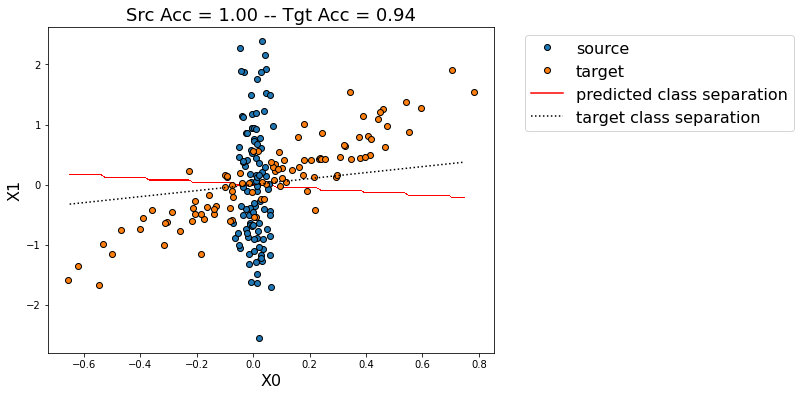

In [3]:
model = LogisticRegression(C=1000)
model.fit(Xs, ys);
scores_s = model.score(Xs, ys)
scores_t = model.score(Xt, yt)

yp_grid = model.predict(X_grid).reshape(100, 100)

plt.figure(figsize=(8,6))
plt.plot(Xs[:, 0], Xs[:, 1], 'o', markeredgecolor="k", label="source")
plt.plot(Xt[:, 0], Xt[:, 1], 'o', markeredgecolor="k", label="target")
plt.contourf(x_grid, y_grid, yp_grid, cmap=cm)
plt.plot([0], [0], c="red", label="predicted class separation")
plt.plot([-0.65, 0.75], [-0.65*0.5, 0.75*0.5], c="black", ls=":", label="target class separation")
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("X0", fontsize=16), plt.ylabel("X1", fontsize=16)
plt.title("Src Acc = %.2f -- Tgt Acc = %.2f"%(scores_s, scores_t), fontsize=18)
plt.show()

## [CORAL](https://adapt-python.github.io/adapt/generated/adapt.feature_based.CORAL.html)

Covariance Matrix alignement...
Previous covariance difference: 0.258273
New covariance difference: 0.021306
Fit estimator...


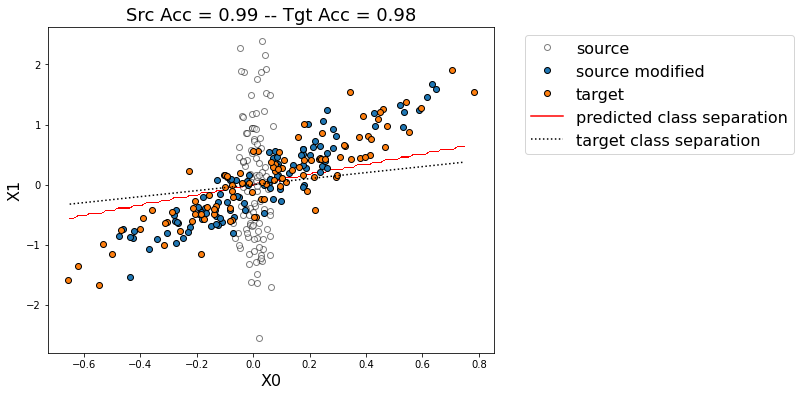

In [4]:
model = CORAL(LogisticRegression(C=1000), lambda_=1000.)
model.fit(Xs, ys, Xt);
scores_s = model.estimator_.score(Xs, ys)
scores_t = model.estimator_.score(Xt, yt)
Xs_enc = model.predict_features(Xs, domain="src")

yp_grid = model.predict(X_grid).reshape(100, 100)

plt.figure(figsize=(8,6))
plt.plot(Xs[:, 0], Xs[:, 1], 'o', color="w", markeredgecolor="k", alpha=0.5, label="source")
plt.plot(Xs_enc[:, 0], Xs_enc[:, 1], 'o', markeredgecolor="k", label="source modified")
plt.plot(Xt[:, 0], Xt[:, 1], 'o', markeredgecolor="k", label="target")
plt.contourf(x_grid, y_grid, yp_grid, cmap=cm)
plt.plot([0], [0], c="red", label="predicted class separation")
plt.plot([-0.65, 0.75], [-0.65*0.5, 0.75*0.5], c="black", ls=":", label="target class separation")
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("X0", fontsize=16), plt.ylabel("X1", fontsize=16)
plt.title("Src Acc = %.2f -- Tgt Acc = %.2f"%(scores_s, scores_t), fontsize=18)
plt.show()

## [DANN](https://adapt-python.github.io/adapt/generated/adapt.feature_based.DANN.html)

In [5]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.Dense(2, activation="sigmoid"))

task = tf.keras.Sequential()
task.add(tf.keras.layers.Dense(1, activation="sigmoid"))

discriminator = tf.keras.Sequential()
discriminator.add(tf.keras.layers.Dense(1, activation="sigmoid"))

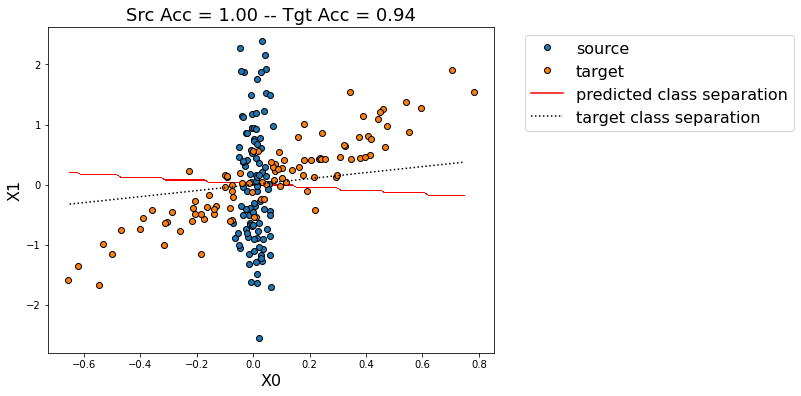

In [6]:
model = DANN(encoder, task, discriminator, lambda_=0.1, random_state=0)
model.fit(Xs, ys, Xt, epochs=500, verbose=0);
scores_s = (np.abs(model.predict(Xs).ravel() - ys)<0.5).mean()
scores_t = (np.abs(model.predict(Xt).ravel() - yt)<0.5).mean()

yp_grid = model.predict(X_grid).reshape(100, 100)>0.5

plt.figure(figsize=(8,6))
plt.plot(Xs[:, 0], Xs[:, 1], 'o', markeredgecolor="k", label="source")
plt.plot(Xt[:, 0], Xt[:, 1], 'o', markeredgecolor="k", label="target")
plt.contourf(x_grid, y_grid, yp_grid, cmap=cm)
plt.plot([0], [0], c="red", label="predicted class separation")
plt.plot([-0.65, 0.75], [-0.65*0.5, 0.75*0.5], c="black", ls=":", label="target class separation")
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("X0", fontsize=16), plt.ylabel("X1", fontsize=16)
plt.title("Src Acc = %.2f -- Tgt Acc = %.2f"%(scores_s, scores_t), fontsize=18)
plt.show()

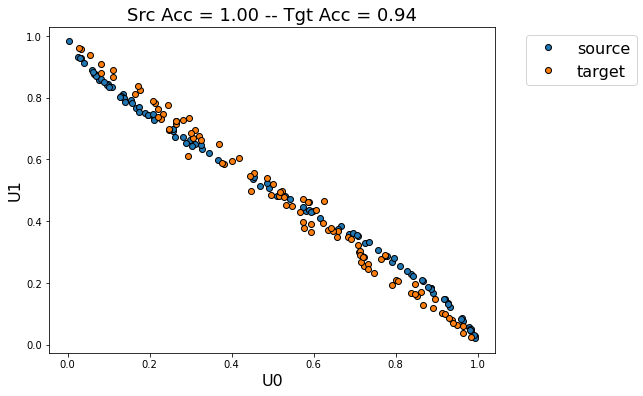

In [7]:
Xs_enc = model.predict_features(Xs)
Xt_enc = model.predict_features(Xt)
plt.figure(figsize=(8,6))
plt.plot(Xs_enc[:, 0], Xs_enc[:, 1], 'o', markeredgecolor="k", label="source")
plt.plot(Xt_enc[:, 0], Xt_enc[:, 1], 'o', markeredgecolor="k", label="target")
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("U0", fontsize=16), plt.ylabel("U1", fontsize=16)
plt.title("Src Acc = %.2f -- Tgt Acc = %.2f"%(scores_s, scores_t), fontsize=18)
plt.show()

## [ADDA](https://adapt-python.github.io/adapt/generated/adapt.feature_based.ADDA.html)

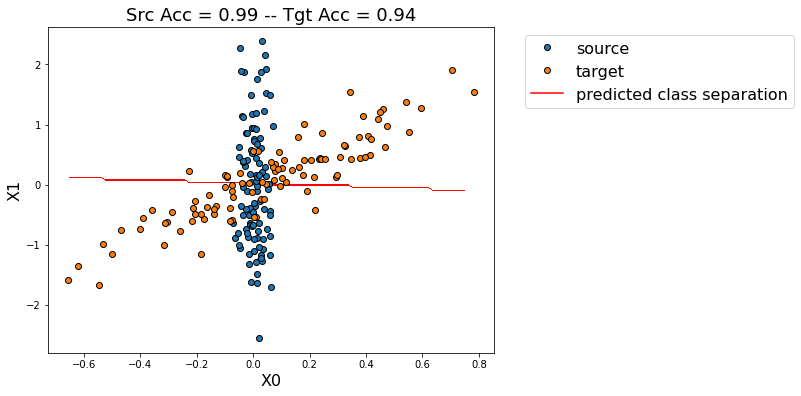

In [8]:
model = ADDA(encoder, task, discriminator, random_state=0)
model.fit(Xs, ys, Xt, epochs=500, verbose=0);
scores_s = (np.abs(model.predict(Xs).ravel() - ys)<0.5).mean()
scores_t = (np.abs(model.predict(Xt).ravel() - yt)<0.5).mean()

yp_grid = model.predict(X_grid).reshape(100, 100)>0.5

plt.figure(figsize=(8,6))
plt.plot(Xs[:, 0], Xs[:, 1], 'o', markeredgecolor="k", label="source")
plt.plot(Xt[:, 0], Xt[:, 1], 'o', markeredgecolor="k", label="target")
plt.contourf(x_grid, y_grid, yp_grid, cmap=cm)
plt.plot([0], [0], c="red", label="predicted class separation")
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("X0", fontsize=16), plt.ylabel("X1", fontsize=16)
plt.title("Src Acc = %.2f -- Tgt Acc = %.2f"%(scores_s, scores_t), fontsize=18)
plt.show()

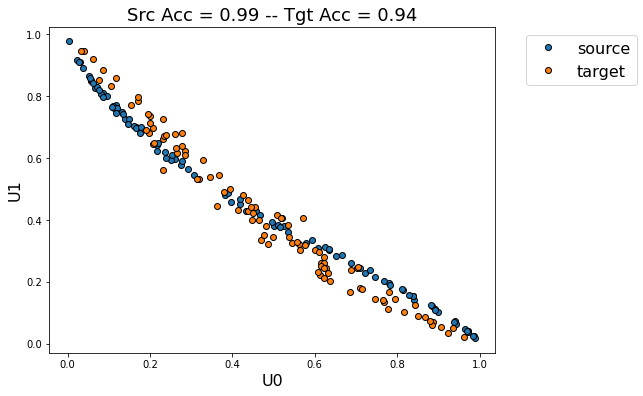

In [9]:
Xs_enc = model.predict_features(Xs)
Xt_enc = model.predict_features(Xt)
plt.figure(figsize=(8,6))
plt.plot(Xs_enc[:, 0], Xs_enc[:, 1], 'o', markeredgecolor="k", label="source")
plt.plot(Xt_enc[:, 0], Xt_enc[:, 1], 'o', markeredgecolor="k", label="target")
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("U0", fontsize=16), plt.ylabel("U1", fontsize=16)
plt.title("Src Acc = %.2f -- Tgt Acc = %.2f"%(scores_s, scores_t), fontsize=18)
plt.show()

## [mSDA](https://adapt-python.github.io/adapt/generated/adapt.feature_based.mSDA.html)

Fit autoencoder...
Fit estimator...


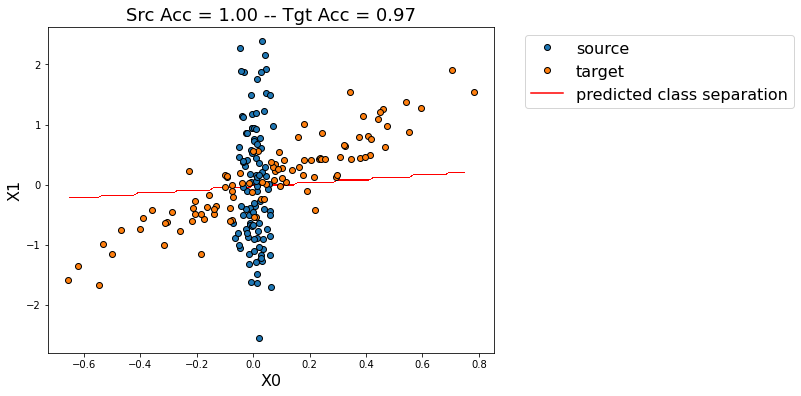

In [10]:
model = mSDA(encoder=encoder, estimator=LogisticRegression(C=1000.), noise_lvl=0.1, random_state=0)
model.fit(Xs, ys, Xt, epochs=500, verbose=0);
scores_s = (np.abs(model.predict(Xs).ravel() - ys)<0.5).mean()
scores_t = (np.abs(model.predict(Xt).ravel() - yt)<0.5).mean()

yp_grid = model.predict(X_grid).reshape(100, 100)>0.5

plt.figure(figsize=(8,6))
plt.plot(Xs[:, 0], Xs[:, 1], 'o', markeredgecolor="k", label="source")
plt.plot(Xt[:, 0], Xt[:, 1], 'o', markeredgecolor="k", label="target")
plt.contourf(x_grid, y_grid, yp_grid, cmap=cm)
plt.plot([0], [0], c="red", label="predicted class separation")
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("X0", fontsize=16), plt.ylabel("X1", fontsize=16)
plt.title("Src Acc = %.2f -- Tgt Acc = %.2f"%(scores_s, scores_t), fontsize=18)
plt.show()

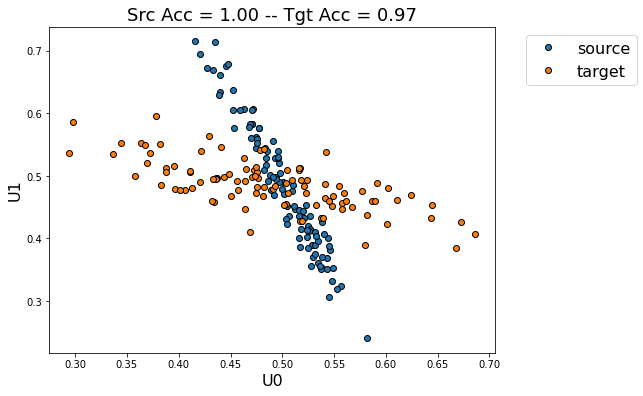

In [11]:
Xs_enc = model.predict_features(Xs)
Xt_enc = model.predict_features(Xt)
plt.figure(figsize=(8,6))
plt.plot(Xs_enc[:, 0], Xs_enc[:, 1], 'o', markeredgecolor="k", label="source")
plt.plot(Xt_enc[:, 0], Xt_enc[:, 1], 'o', markeredgecolor="k", label="target")
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("U0", fontsize=16), plt.ylabel("U1", fontsize=16)
plt.title("Src Acc = %.2f -- Tgt Acc = %.2f"%(scores_s, scores_t), fontsize=18)
plt.show()